<a href="https://colab.research.google.com/github/fire-classifying/fireclass/blob/master/fire_classify_2classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Ejecuta esta celda para activar tu cuenta de Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
!pip install fastai==0.7.0


In [0]:
# En primer lugar importamos las librerías

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from fastai.imports import *
from fastai.structured import *
from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline 

RANDOM_SEED = 33

plt.style.use('bmh')

In [10]:
# Iniciamos el proceso de análisis, estudiando los datos disponibles

df = pd.read_csv('/content/drive/My Drive/Incendios_dataset.csv', delimiter = ',') 

df.head(10)

,fecha,Mod_comb,NDVI,sup_quemad,sup_arb,sup_pastiz,sup_matorr,w_arb,w_pastiz,w_matorr,rk_Cuenc_F,rk_hist_Cu,rk_hist_us,rk_orograf,rk_peligro,rk_pte,vuln_equip,vuln_forve,vuln_infra,vuln_max,vuln_pathi,LST,rk_combUSIF,rk_combCuencExtr,rk_combCuencSup,Velocidad_Viento,Dirección_Viento,Humedad_Relativa,Temperatura_Máxima,Temperatura_Media,ETo_acumulada,Precipitación_acumulada
0,13/08/2008,7.0,3747.28,37.900002,37.900002,0.000000,0.000000,1.000000,0.000000,0.000000,5,5,2,2,1,1,1,4,2,4,1,39.19,4,4,3,1.0,310.0,43.0,34.0,23.8,1043.41,487.4
1,30/06/2008,4.0,3981.50,17.077999,16.073999,1.004000,0.000000,0.941211,0.058789,0.000000,5,5,5,2,3,4,1,4,5,5,1,33.99,5,5,4,1.6,268.8,48.6,38.4,28.9,968.59,658.2
2,15/07/2009,1.0,3811.66,18.040001,0.180000,14.740000,3.120000,0.009978,0.817073,0.172949,3,4,3,3,1,2,1,4,3,4,1,42.45,5,4,4,1.6,240.0,38.0,37.0,26.1,1087.09,411.0
3,25/07/2009,10.0,3536.00,10.120000,0.000000,10.120000,0.000000,0.000000,1.000000,0.000000,5,5,3,2,2,1,1,3,5,5,1,46.99,5,5,4,1.2,292.0,42.5,39.2,29.1,1129.46,508.2
4,28/05/2009,NaN,2132.06,56.220001,15.590000,0.000000,40.630001,0.277303,0.000000,0.722697,5,5,3,2,1,1,1,3,5,5,1,33.75,5,5,5,1.3,290.0,37.4,33.3,24.5,741.75,495.2
5,24/06/2009,NaN,NaN,11.000000,0.000000,11.000000,0.000000,0.000000,1.000000,0.000000,4,4,5,2,1,1,1,3,4,4,1,43.05,5,5,5,2.0,298.4,80.1,29.7,22.7,884.09,369.2
6,03/07/2009,3.0,2384.00,27.180000,6.850000,9.479999,10.850000,0.252024,0.348786,0.399191,4,3,1,2,2,1,1,3,5,5,1,47.89,1,1,1,2.0,290.0,77.0,38.7,29.2,963.57,439.8
7,14/08/2009,NaN,NaN,11.979999,8.720000,1.230000,2.030000,0.727880,0.102671,0.169449,3,4,2,2,1,1,1,4,5,5,1,40.25,4,5,5,2.2,323.1,28.0,37.3,28.4,1344.11,548.2
8,28/08/2010,6.0,4338.80,29.169001,21.518000,0.631000,7.020000,0.737701,0.021633,0.240666,5,5,5,2,3,4,1,4,3,4,1,41.77,5,5,5,1.5,230.0,68.1,38.4,30.1,1289.75,1256.4
9,25/07/2010,1.0,4090.40,27.150000,2.200000,0.000000,24.950001,0.081031,0.000000,0.918969,5,4,2,2,2,1,1,4,2,4,1,36.49,4,3,2,1.6,254.0,78.0,35.6,27.5,1179.75,901.0


In [11]:
df.columns

Index(['fecha', 'Mod_comb', 'NDVI', 'sup_quemad', 'sup_arb', 'sup_pastiz',
       'sup_matorr', 'w_arb', 'w_pastiz', 'w_matorr', 'rk_Cuenc_F',
       'rk_hist_Cu', 'rk_hist_us', 'rk_orograf', 'rk_peligro', 'rk_pte',
       'vuln_equip', 'vuln_forve', 'vuln_infra', 'vuln_max', 'vuln_pathi',
       'LST', 'rk_combUSIF', 'rk_combCuencExtr', 'rk_combCuencSup',
       'Velocidad_Viento', 'Dirección_Viento', 'Humedad_Relativa',
       'Temperatura_Máxima', 'Temperatura_Media', 'ETo_acumulada',
       'Precipitación_acumulada'],
      dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 32 columns):
fecha                      110 non-null object
Mod_comb                   98 non-null float64
NDVI                       102 non-null float64
sup_quemad                 110 non-null float64
sup_arb                    66 non-null float64
sup_pastiz                 66 non-null float64
sup_matorr                 66 non-null float64
w_arb                      66 non-null float64
w_pastiz                   66 non-null float64
w_matorr                   66 non-null float64
rk_Cuenc_F                 110 non-null int64
rk_hist_Cu                 110 non-null int64
rk_hist_us                 110 non-null int64
rk_orograf                 110 non-null int64
rk_peligro                 110 non-null int64
rk_pte                     110 non-null int64
vuln_equip                 110 non-null int64
vuln_forve                 110 non-null int64
vuln_infra                 110 non-null int64
vuln_max 

# Data Mining

In [0]:
# Añadimos columnas fechaYear, FechaMonth, etc al dataset
add_datepart(df, 'fecha')

In [0]:
# imputacion de valores NaN mediante el valor medio de cada columna

def impute_nan_by_mean(dataframe):
 
 df = dataframe.copy()
 list_columns = df.columns[df.columns != 'category'] #-> Esto no está funcionando bien. Aquí sí, porque aún no hemos creado categorías
 
 for var in list_columns:
   
   #if type(dataframe[var]) != "category":
     mean_var = df[var].mean()
     df[var] = df[var].replace(np.nan, mean_var)
 
 return df

In [0]:
df = impute_nan_by_mean(df)

In [0]:
# El campo 'cat_incendio' lo categorizamos en función de la superficie quemada
# 1 -> pequeño (sup < 200Ha)
# 2 -> grande (sup > 200 Ha)
binInterval = [0,200,100000] 
binLabels = [1,2] 
df['cat_incendio'] = pd.cut(df['sup_quemad'], bins = binInterval, labels=binLabels)

In [17]:
import collections
print(collections.Counter(df.cat_incendio))

Counter({1: 82, 2: 28})


In [0]:
# El campo 'cat_dir_viento' lo categorizamos en función de la dirección del viento
# 0 = dir < 45º
# 1 = 45º < dir < 90º
# 2 = 90º < dir < 135º
# 3 = 135º < dir < 180º
# 4 = 180º < dir < 225º
# 5 = 225º < dir < 270º
# 6 = 270º < dir < 315º
# 7 = 315º < dir < 360º

binInterval = [-1,45,90,135,180,225,270,315,360] 
binLabels = [0,1,2,3,4,5,6,7] 
df['cat_dir_viento'] = pd.cut(df['Dirección_Viento'], bins = binInterval, labels=binLabels)

In [0]:
# Añadimos una columna nueva y eliminamos las dos originales
df['ned_hidricas'] = df.ETo_acumulada - df.Precipitación_acumulada
df.drop('ETo_acumulada', axis = 1, inplace = True)
df.drop('Precipitación_acumulada', axis = 1, inplace = True)

In [0]:
# Hacemos lo mismo con la vulnerabilidad, sustituyéndola por una media de las existentes
df['vulnerabilidad'] = df[['vuln_equip','vuln_forve','vuln_infra','vuln_max','vuln_pathi']].mean(axis = 1)
df.drop('vuln_equip', axis = 1, inplace = True)
df.drop('vuln_forve', axis = 1, inplace = True)
df.drop('vuln_infra', axis = 1, inplace = True)
df.drop('vuln_max', axis = 1, inplace = True)
df.drop('vuln_pathi', axis = 1, inplace = True)

In [0]:
#Eliminamos los riesgos de cuenca y modelos combustible por una variable única llamada riesgos. Los demás riesgos entendemos que deben existir

df['riesgos_generales_cuenca'] = df[['rk_Cuenc_F','rk_hist_Cu','rk_hist_us','rk_combUSIF','rk_combCuencExtr','rk_combCuencSup']].mean(axis = 1)
df.drop('rk_Cuenc_F', axis = 1, inplace = True)
df.drop('rk_hist_Cu', axis = 1, inplace = True)
df.drop('rk_hist_us', axis = 1, inplace = True)
df.drop('rk_combUSIF', axis = 1, inplace = True)
df.drop('rk_combCuencExtr', axis = 1, inplace = True)
df.drop('rk_combCuencSup', axis = 1, inplace = True)

In [0]:
#Eliminamos los riesgos de pendientes y orografía por una sola variable
df['riesgos_pendientes'] = df[['rk_orograf','rk_pte']].mean(axis = 1)
df.drop('rk_orograf', axis = 1, inplace = True)
df.drop('rk_pte', axis = 1, inplace = True)

In [0]:
#Eliminamos las variables que están correlacionadas con la variable respuesta
df.drop('sup_arb', axis = 1, inplace = True)
df.drop('sup_pastiz', axis = 1, inplace = True)
df.drop('sup_matorr', axis = 1, inplace = True)
df.drop('w_arb', axis = 1, inplace = True)
df.drop('w_pastiz', axis = 1, inplace = True)
df.drop('w_matorr', axis = 1, inplace = True)

In [0]:
# Normalizamos el NDVI para que tome valores entre -1 y 1
df['ndvi_norm'] = ((df.NDVI -df.NDVI.mean())/df.NDVI.std())+(3/6)

In [0]:
#Eliminación de la temperatura máxima
df.drop('Temperatura_Máxima', axis = 1, inplace = True)

In [0]:
# Redondear valor de Mod_comb

df['Mod_comb']=round(df['Mod_comb'])

In [27]:
df.columns

Index(['Mod_comb', 'NDVI', 'sup_quemad', 'rk_peligro', 'LST',
       'Velocidad_Viento', 'Dirección_Viento', 'Humedad_Relativa',
       'Temperatura_Media', 'fechaYear', 'fechaMonth', 'fechaWeek', 'fechaDay',
       'fechaDayofweek', 'fechaDayofyear', 'fechaIs_month_end',
       'fechaIs_month_start', 'fechaIs_quarter_end', 'fechaIs_quarter_start',
       'fechaIs_year_end', 'fechaIs_year_start', 'fechaElapsed',
       'cat_incendio', 'cat_dir_viento', 'ned_hidricas', 'vulnerabilidad',
       'riesgos_generales_cuenca', 'riesgos_pendientes', 'ndvi_norm'],
      dtype='object')

In [28]:
df.head()

,Mod_comb,NDVI,sup_quemad,rk_peligro,LST,Velocidad_Viento,Dirección_Viento,Humedad_Relativa,Temperatura_Media,fechaYear,fechaMonth,fechaWeek,fechaDay,fechaDayofweek,fechaDayofyear,fechaIs_month_end,fechaIs_month_start,fechaIs_quarter_end,fechaIs_quarter_start,fechaIs_year_end,fechaIs_year_start,fechaElapsed,cat_incendio,cat_dir_viento,ned_hidricas,vulnerabilidad,riesgos_generales_cuenca,riesgos_pendientes,ndvi_norm
0,7.0,3747.28,37.900002,1,39.19,1.0,310.0,43.0,23.8,2008,8,33,13,2,226,False,False,False,False,False,False,1218585600,1,6,556.01,2.4,3.833333,1.5,0.469908
1,4.0,3981.50,17.077999,3,33.99,1.6,268.8,48.6,28.9,2008,6,27,30,0,182,True,False,True,False,False,False,1214784000,1,5,310.39,3.2,4.833333,3.0,0.548545
2,1.0,3811.66,18.040001,1,42.45,1.6,240.0,38.0,26.1,2009,7,29,15,2,196,False,False,False,False,False,False,1247616000,1,5,676.09,2.6,3.833333,2.5,0.491523
3,10.0,3536.00,10.120000,2,46.99,1.2,292.0,42.5,29.1,2009,7,30,25,5,206,False,False,False,False,False,False,1248480000,1,6,621.26,3.0,4.500000,1.5,0.398973
4,6.0,2132.06,56.220001,1,33.75,1.3,290.0,37.4,24.5,2009,5,22,28,3,148,False,False,False,False,False,False,1243468800,1,6,246.55,3.0,4.666667,1.5,-0.072385


In [0]:
# Eliminar columnas innecesarias

df.drop(['sup_quemad','fechaYear', 'fechaIs_month_end',
       'fechaIs_month_start', 'fechaIs_quarter_end', 'fechaIs_quarter_start',
       'fechaIs_year_end', 'fechaIs_year_start', 'fechaElapsed', 'NDVI', 'Dirección_Viento'], axis = 1, inplace = True)


In [0]:
# Eliminar nas en variable a predecir
df1= df.dropna(axis=0)


In [0]:
df1.to_csv("/content/drive/My Drive/Incendios_dataset_model.csv")

#Train/Test y Estandarización

In [31]:
df1.columns

Index(['Mod_comb', 'rk_peligro', 'LST', 'Velocidad_Viento', 'Humedad_Relativa',
       'Temperatura_Media', 'fechaMonth', 'fechaWeek', 'fechaDay',
       'fechaDayofweek', 'fechaDayofyear', 'cat_incendio', 'cat_dir_viento',
       'ned_hidricas', 'vulnerabilidad', 'riesgos_generales_cuenca',
       'riesgos_pendientes', 'ndvi_norm'],
      dtype='object')

In [0]:
#Se separan las entradas de las salidas
    outputs = df1.iloc[:,11]
    data_=df1.drop(['cat_incendio'],axis=1)
    inputs = data_.iloc[:,:]
    Input_Data = inputs.values[:,:]
    Output_Data = list(outputs.values[:])

In [0]:
# Separacion muestra: entrenamiento y test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Input_Data,Output_Data,test_size=0.3, stratify=df1.cat_incendio)

In [0]:
# Normalizar valores antes de introducir en el modelo
Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

# Primera aproximación modelos (sin optimizar)

In [35]:
from sklearn.metrics import accuracy_score, log_loss, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss", "Recall"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    train_predictions = clf.predict(X_test)
    recall = recall_score(y_test, train_predictions)
    print("Recall: {}".format(recall))
    
    log_entry = pd.DataFrame([[name, acc*100, ll, recall]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 75.7576%
Log Loss: 1.3902499511685136
Recall: 0.88
SVC
****Results****
Accuracy: 75.7576%
Log Loss: 0.5354097239248681
Recall: 1.0
NuSVC
****Results****
Accuracy: 78.7879%
Log Loss: 0.5552886235306624
Recall: 0.96
DecisionTreeClassifier
****Results****
Accuracy: 72.7273%
Log Loss: 9.419666289521095
Recall: 0.84
RandomForestClassifier
****Results****
Accuracy: 87.8788%
Log Loss: 0.42491944864605163
Recall: 1.0
AdaBoostClassifier
****Results****
Accuracy: 84.8485%
Log Loss: 0.5909856579888715
Recall: 0.96
GradientBoostingClassifier
****Results****
Accuracy: 75.7576%
Log Loss: 0.621639836916512
Recall: 0.88
GaussianNB
****Results****
Accuracy: 75.7576%
Log Loss: 1.279628192237524
Recall: 0.76
LinearDiscriminantAnalysis
****Results****
Accuracy: 69.6970%
Log Loss: 0.5994020283255567
Recall: 0.8
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 75.7576%
Log Loss: 7.63487822493731
Recall: 1.0


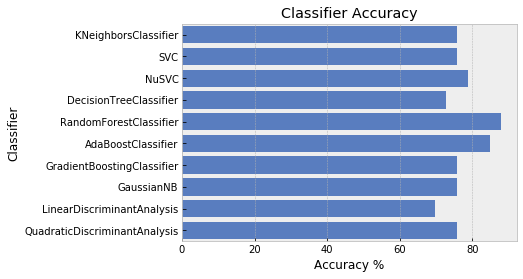

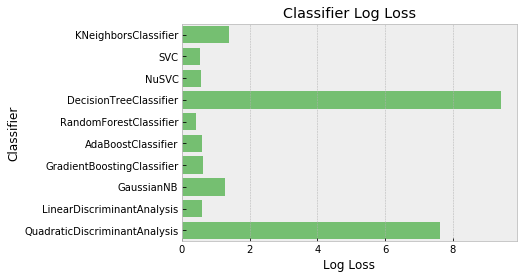

In [36]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

# RANDOM FOREST

In [0]:
from random import seed
seed(12345)

In [0]:
# Parámetros para optimizar el modelo de RF
criterion = ['gini','entropy']
n=[5,10,20,50]
depth=[2,3,5,8,10,30,100]

param_grid = {'criterion': criterion,
              'n_estimators': n,
             'max_depth':depth}


In [0]:
# GridSearch con modelo RF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
grid = GridSearchCV(RandomForestClassifier(),param_grid=param_grid,n_jobs=1,cv=10,verbose=True, scoring = 'recall')

In [92]:
# Entrenar modelo
#y_test_orig= lb.inverse_transform(y_test, threshold=0.5)
grid.fit(X_train,y_train)
pred = grid.predict(X_test)
m_best = grid.best_estimator_
score = grid.score(X_test,y_test)


Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed:    9.8s finished


In [93]:
conf_mat = confusion_matrix(y_test,pred)
print(conf_mat)
print(score)
print(m_best)

[[23  2]
 [ 5  3]]
0.92
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [94]:
from sklearn.metrics import precision_score
y_pred = m_best.predict(X_test)
precision_score(y_test, y_pred)

0.8214285714285714

In [95]:
## Metricas de validación
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.82      0.92      0.87        25
     class 2       0.60      0.38      0.46         8

    accuracy                           0.79        33
   macro avg       0.71      0.65      0.66        33
weighted avg       0.77      0.79      0.77        33



In [96]:
grid.best_estimator_.feature_importances_

array([0.03513, 0.03298, 0.05077, 0.13643, 0.0647 , 0.13169, 0.01137, 0.0651 , 0.0537 , 0.03844, 0.07088,
       0.03912, 0.06041, 0.08248, 0.03418, 0.02096, 0.07166])

In [97]:
data_.columns

Index(['Mod_comb', 'rk_peligro', 'LST', 'Velocidad_Viento', 'Humedad_Relativa',
       'Temperatura_Media', 'fechaMonth', 'fechaWeek', 'fechaDay',
       'fechaDayofweek', 'fechaDayofyear', 'cat_dir_viento', 'ned_hidricas',
       'vulnerabilidad', 'riesgos_generales_cuenca', 'riesgos_pendientes',
       'ndvi_norm'],
      dtype='object')

In [0]:
import pandas as pd
feature_importances = pd.DataFrame(grid.best_estimator_.feature_importances_,
                                   index = data_.columns,
                                    columns=['importance']).sort_values('importance',     
                                                                        ascending=False)

In [104]:
feature_importances

,importance
Velocidad_Viento,0.136431
Temperatura_Media,0.131695
vulnerabilidad,0.082475
ndvi_norm,0.071657
fechaDayofyear,0.070876
fechaWeek,0.065101
Humedad_Relativa,0.064703
ned_hidricas,0.060414
fechaDay,0.053696
LST,0.050767


In [105]:
df1.columns[11]

'cat_incendio'

In [0]:
#Se separan las entradas de las salidas, también nos quedamos con las columnas que nos parecen importantes
    outputs = df1.iloc[:,11]
    data_=df1.drop(['cat_incendio'],axis=1)
    inputs = data_[[ 'LST', 'Velocidad_Viento', 'Humedad_Relativa',
       'Temperatura_Media', 
         'ned_hidricas',
       'vulnerabilidad',
       'ndvi_norm']]
    Input_Data = inputs.values[:,:]
    Output_Data = list(outputs.values[:])


In [107]:
df1.columns

Index(['Mod_comb', 'rk_peligro', 'LST', 'Velocidad_Viento', 'Humedad_Relativa',
       'Temperatura_Media', 'fechaMonth', 'fechaWeek', 'fechaDay',
       'fechaDayofweek', 'fechaDayofyear', 'cat_incendio', 'cat_dir_viento',
       'ned_hidricas', 'vulnerabilidad', 'riesgos_generales_cuenca',
       'riesgos_pendientes', 'ndvi_norm'],
      dtype='object')

In [0]:
X_train,X_test,y_train,y_test = train_test_split(Input_Data,Output_Data,test_size=0.3, stratify=df1.cat_incendio)
# Normalizar valores antes de introducir en el modelo
Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

In [109]:
rf = GridSearchCV(RandomForestClassifier(),param_grid=param_grid,n_jobs=1,cv=10,verbose=True,scoring='recall')

rf.fit(X_train,y_train)
pred = rf.predict(X_test)
score = rf.score(X_test,y_test)

conf_mat = confusion_matrix(y_test,pred)
print(conf_mat)
print(score)

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[25  0]
 [ 7  1]]
1.0


[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed:    9.5s finished


In [110]:
## Metricas de validación
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.79      0.88      0.83        25
     class 2       0.40      0.25      0.31         8

    accuracy                           0.73        33
   macro avg       0.59      0.56      0.57        33
weighted avg       0.69      0.73      0.70        33



#Reducimos el balanceo

Decision tree classifier performance:
Balanced accuracy: 0.48 - Geometric mean 0.42
[[18  7]
 [ 6  2]]



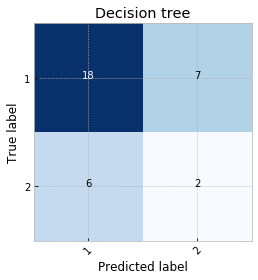

In [134]:
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score

def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    print('')

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print('Decision tree classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, pred),
              geometric_mean_score(y_test, pred)))
cm_tree = confusion_matrix(y_test, pred)
fig, ax = plt.subplots()
plot_confusion_matrix(cm_tree, classes=np.unique(outputs), ax=ax,
                      title='Decision tree')



In [0]:
## Classification using bagging classifier with and without sampling
from imblearn.ensemble import BalancedBaggingClassifier


bagging = BaggingClassifier(n_estimators=50, random_state=0, n_jobs=-1)
balanced_bagging = BalancedBaggingClassifier(n_estimators=50, random_state=0,
                                             n_jobs=-1)

bagging.fit(X_train, y_train)
balanced_bagging.fit(X_train, y_train)

y_pred_bc = bagging.predict(X_test)
y_pred_bbc = balanced_bagging.predict(X_test)

Bagging classifier performance:
Balanced accuracy: 0.48 - Geometric mean 0.42
[[18  7]
 [ 6  2]]

Balanced Bagging classifier performance:
Balanced accuracy: 0.53 - Geometric mean 0.50
[[17  8]
 [ 5  3]]



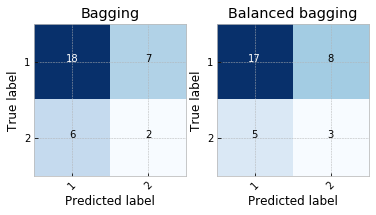

In [138]:
print('Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_bc),
              geometric_mean_score(y_test, y_pred_bc)))
cm_bagging = confusion_matrix(y_test, y_pred_bc)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_bagging, classes=np.unique(outputs), ax=ax[0],
                      title='Bagging')

print('Balanced Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_bbc),
              geometric_mean_score(y_test, y_pred_bbc)))
cm_balanced_bagging = confusion_matrix(y_test, y_pred_bbc)
plot_confusion_matrix(cm_balanced_bagging, classes=np.unique(outputs),
                      ax=ax[1], title='Balanced bagging')

Random Forest classifier performance:
Balanced accuracy: 0.48 - Geometric mean 0.32
[[21  4]
 [ 7  1]]

Balanced Random Forest classifier performance:
Balanced accuracy: 0.53 - Geometric mean 0.50
[[17  8]
 [ 5  3]]



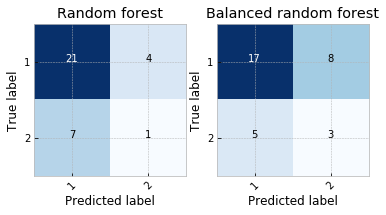

In [140]:
## Classification using random forest classifier with and without sampling
from imblearn.ensemble import BalancedRandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=-1)
brf = BalancedRandomForestClassifier(n_estimators=50, random_state=0,
                                     n_jobs=-1)

rf.fit(X_train, y_train)
brf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_brf = brf.predict(X_test)

# Similarly to the previous experiment, the balanced classifier outperform the
# classifier which learn from imbalanced bootstrap samples. In addition, random
# forest outsperforms the bagging classifier.

print('Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_rf),
              geometric_mean_score(y_test, y_pred_rf)))
cm_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_rf, classes=np.unique(outputs), ax=ax[0],
                      title='Random forest')

print('Balanced Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_brf),
              geometric_mean_score(y_test, y_pred_brf)))
cm_brf = confusion_matrix(y_test, y_pred_brf)
plot_confusion_matrix(cm_brf, classes=np.unique(outputs), ax=ax[1],
                      title='Balanced random forest')

# MLP

In [0]:
# Parámetros para optimizar el modelo de MLP
parameter_grid_MLP = {
            'hidden_layer_sizes': [(10),(30),(50),(100),(10,10),(30,30),(50,50),(100,100)],
            'solver': ['lbfgs','sgd','adam'],
            'activation' : ['identity','logistic','tanh','relu'],
            'learning_rate': ['constant','adaptive'],
            'alpha': [0.0001,0.001,0.005,0.01]
            }

In [112]:
##MLP###
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

mlp = GridSearchCV(MLPClassifier(early_stopping=True),param_grid=parameter_grid_MLP,cv=5,verbose=True,n_jobs=-2)
mlp.fit(X_train,y_train)
params= mlp.best_params_
pred= mlp.predict(X_test)
score= mlp.score(X_test, y_test)
mat= confusion_matrix(y_test,pred)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 3840 out of 3840 | elapsed:  2.5min finished


In [113]:
## Metricas de validación
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2']
print(classification_report(y_test, pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.76      0.76      0.76        25
     class 2       0.25      0.25      0.25         8

    accuracy                           0.64        33
   macro avg       0.51      0.51      0.51        33
weighted avg       0.64      0.64      0.64        33



# GRADIENT BOOSTING

In [114]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.818
Accuracy score (validation): 0.727

Learning rate:  0.1
Accuracy score (training): 0.935
Accuracy score (validation): 0.697

Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.697

Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.636

Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.697

Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.697



In [115]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.5, max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_train, y_train)
predictions = gb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[19  6]
 [ 6  2]]

Classification Report
              precision    recall  f1-score   support

           1       0.76      0.76      0.76        25
           2       0.25      0.25      0.25         8

    accuracy                           0.64        33
   macro avg       0.51      0.51      0.51        33
weighted avg       0.64      0.64      0.64        33



# XGBOOST

In [116]:
import xgboost as xgb
from scipy.stats import uniform, randint

xgb_model = xgb.XGBClassifier()
    
parameter_grid_XGBOOST = {
            'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
            }
    
    
xgb = GridSearchCV(xgb_model, param_grid=parameter_grid_XGBOOST, cv=3, verbose=1, n_jobs=1, return_train_score=True)
xgb.fit(X_train,np.ravel(y_train))
pred = xgb.predict(X_test)
score = xgb.score(X_test,y_test)
   
conf_mat = confusion_matrix(y_test,pred)
print(conf_mat)
print(score)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[21  4]
 [ 6  2]]
0.696969696969697


[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed:   14.7s finished


In [117]:
## Metricas de validación
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2']
print(classification_report(y_test, pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.78      0.84      0.81        25
     class 2       0.33      0.25      0.29         8

    accuracy                           0.70        33
   macro avg       0.56      0.54      0.55        33
weighted avg       0.67      0.70      0.68        33



# BAGGING

In [118]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


n=[10,50,70,80,100]
base= [DecisionTreeClassifier(),KNeighborsClassifier()]
param_grid = {'n_estimators': n,
                  'base_estimator':base}

grid = GridSearchCV(BaggingClassifier(),param_grid=param_grid,n_jobs=-2,cv=10,verbose=True)
    
grid.fit(X_train,np.ravel(y_train))
pred = grid.predict(X_test)
score = grid.score(X_test,np.ravel(y_test))
   
conf_mat = confusion_matrix(y_test,pred)
print(conf_mat)
print(score)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


[[18  7]
 [ 6  2]]
0.6060606060606061


[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    5.7s finished


In [119]:
## Metricas de validación
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2']
print(classification_report(y_test, pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.75      0.72      0.73        25
     class 2       0.22      0.25      0.24         8

    accuracy                           0.61        33
   macro avg       0.49      0.48      0.48        33
weighted avg       0.62      0.61      0.61        33



# ADABOOST CLASSIFIER

In [120]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ada_model=AdaBoostClassifier(base_estimator=dtc, n_estimators=100)
ada_model=ada_model.fit(X_train,y_train)
print(ada_model)
AdaBoostClassifier(algorithm='SAMME.R',
    base_estimator=DecisionTreeClassifier(class_weight=None, 
    criterion='entropy',max_depth=3,
    max_features=None, max_leaf_nodes=None,
    min_impurity_decrease=0.0, min_impurity_split=None,
    min_samples_leaf=1, min_samples_split=2,
    min_weight_fraction_leaf=0.0, presort=False, random_state=None,
    splitter='best'),
    learning_rate=1.0, n_estimators=100, random_state=None)

ytest_pred=ada_model.predict(X_test)
print(ada_model.score(X_test, y_test))

print(confusion_matrix(y_test, ytest_pred))

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                          

In [121]:
## Metricas de validación
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2']
print(classification_report(y_test, ytest_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.75      0.84      0.79        25
     class 2       0.20      0.12      0.15         8

    accuracy                           0.67        33
   macro avg       0.47      0.48      0.47        33
weighted avg       0.62      0.67      0.64        33



# CatBoostClassifier

In [122]:
!pip install catboost

In [0]:
from catboost import CatBoostClassifier
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [126]:
    model = CatBoostClassifier()
    parameters = {'depth'         : sp_randInt(4, 10),
                  'learning_rate' : sp_randFloat(),
                  'iterations'    : sp_randInt(10, 100)
                 }
    
    randm = GridSearchCV(estimator=model, param_grid = parameters, 
                               cv = 2,  n_jobs=-1)
    randm.fit(X_train, y_train)

    # Results from Random Search
    print("\n========================================================")
    print(" Results from Random Search " )
    print("========================================================")    
    
    print("\n The best estimator across ALL searched params:\n",
          randm.best_estimator_)
    
    print("\n The best score across ALL searched params:\n",
          randm.best_score_)
    
    print("\n The best parameters across ALL searched params:\n",
          randm.best_params_)
    
    print("\n ========================================================")

ValueError: ignored

# SVC

In [157]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1000, 'kernel': 'linear'}

Grid scores on development set:

0.370 (+/-0.008) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.370 (+/-0.008) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.370 (+/-0.008) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.370 (+/-0.008) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.422 (+/-0.209) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.370 (+/-0.008) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.618 (+/-0.483) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.422 (+/-0.209) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.478 (+/-0.264) for {'C': 1, 'kernel': 'linear'}
0.660 (+/-0.343) for {'C': 10, 'kernel': 'linear'}
0.660 (+/-0.343) for {'C': 100, 'kernel': 'linear'}
0.666 (+/-0.360) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full 

# Logistic Classifier

In [155]:
from sklearn.linear_model import LogisticRegression
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)



logistic_mod = GridSearchCV(LogisticRegression(),param_grid = hyperparameters, 
                               cv = 2,  n_jobs=-1)

model_res = logistic_mod.fit(X_train, y_train)

ytest_pred=model_res.predict(X_test)
print(model_res.score(X_test, y_test))

print(confusion_matrix(y_test, ytest_pred))

0.7878787878787878
[[23  2]
 [ 5  3]]


In [156]:
## Metricas de validación
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2']
print(classification_report(y_test, ytest_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.82      0.92      0.87        25
     class 2       0.60      0.38      0.46         8

    accuracy                           0.79        33
   macro avg       0.71      0.65      0.66        33
weighted avg       0.77      0.79      0.77        33



In [0]:
## BALANCEO 

In [0]:
## Boosting classifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import RUSBoostClassifier

base_estimator = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
eec = EasyEnsembleClassifier(n_estimators=10,
                             base_estimator=base_estimator,
                             n_jobs=-1)
eec.fit(X_train, y_train)
y_pred_eec = eec.predict(X_test)
print('Easy ensemble classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_eec),
              geometric_mean_score(y_test, y_pred_eec)))
cm_eec = confusion_matrix(y_test, y_pred_eec)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_eec, classes=np.unique(outputs), ax=ax[0],
                      title='Easy ensemble classifier')

rusboost = RUSBoostClassifier(n_estimators=10,
                              base_estimator=base_estimator)
rusboost.fit(X_train, y_train)
y_pred_rusboost = rusboost.predict(X_test)
print('RUSBoost classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_rusboost),
              geometric_mean_score(y_test, y_pred_rusboost)))
cm_rusboost = confusion_matrix(y_test, y_pred_rusboost)
plot_confusion_matrix(cm_rusboost, classes=np.unique(outputs),
                      ax=ax[1], title='RUSBoost classifier')

plt.show()

# AÑADIR NUEVAS MUESTRAS ARTIFICIALES